# **Práctica 2: CLUSTERING (AGRUPACIÓN) DE SEMILLAS**
- Alfredo Marías Felices Vera 100495820@alumnos.uc3m.es
- Liang Ji Zhu 100495723@alumnos.uc3m.es
- Grupo 20

# Estructura del Notebook:
1. Cargar datos
2. Evaluacion de Escalers mediante PCA
3. Clustering
   1. K-Means
   2. Clustering Jerárquico
   3. DBSCAN
   4. Evaluación
4. Evaluación de Silueta
5. Análisis
6. Conclusión

# 1. Cargar datos

Número óptimo de clusters: 2
Altura de fusión óptima: 2.20
Número de clusters encontrados: 1
Número de outliers encontrados: 1
x_point=175 y_value=0.11582792214564624
Número de clusters encontrados: 3
Número de outliers encontrados: 19
Puntajes de Silueta:
K-Means: 0.50
Jerárquico: 0.47


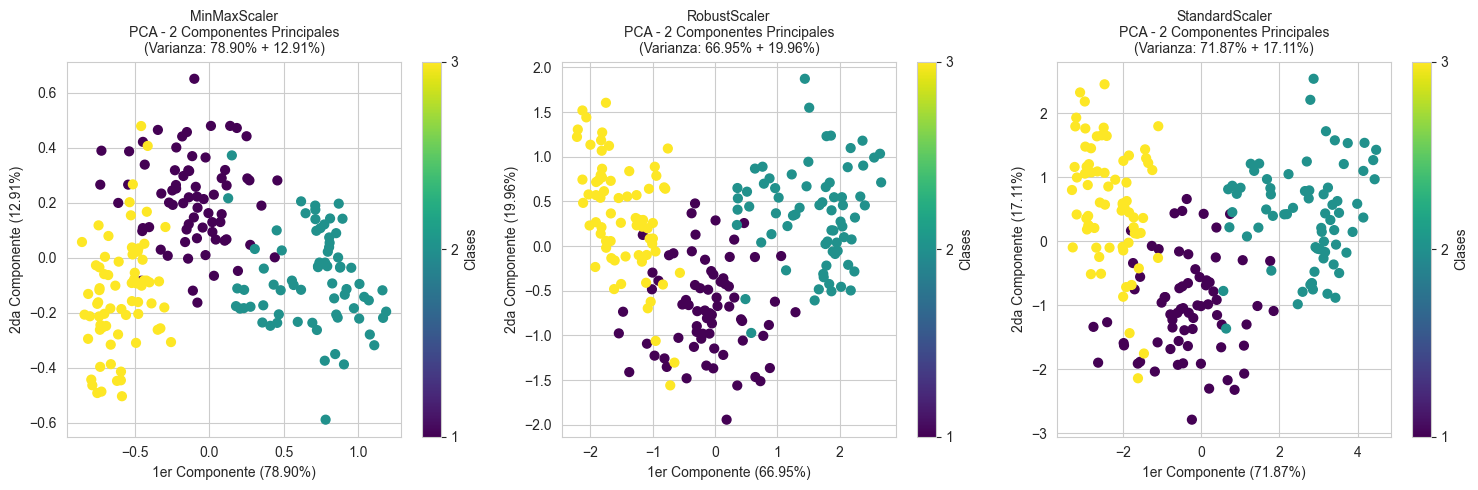

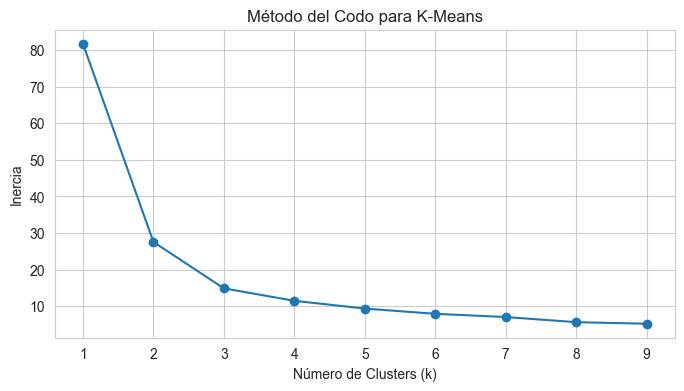

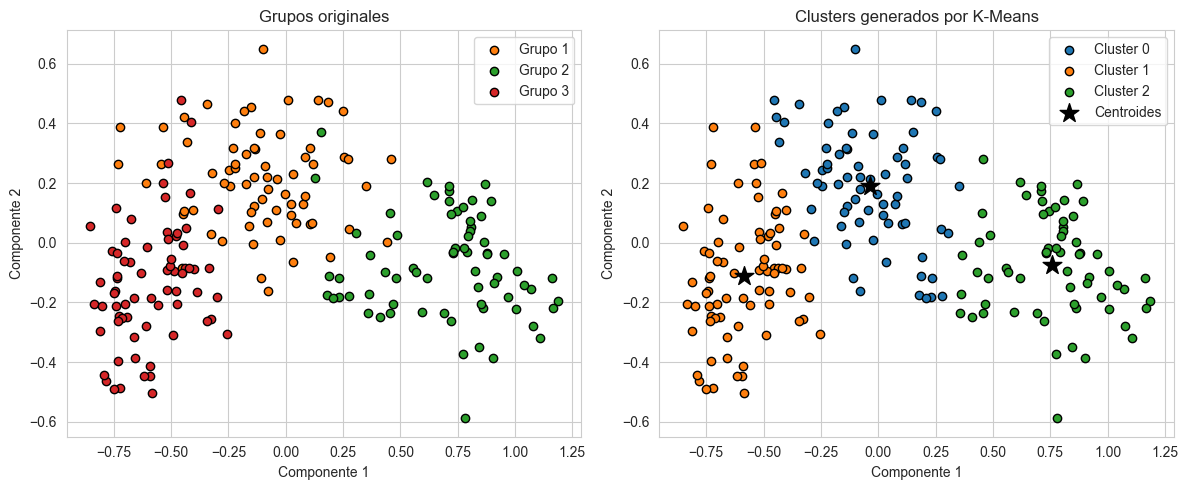

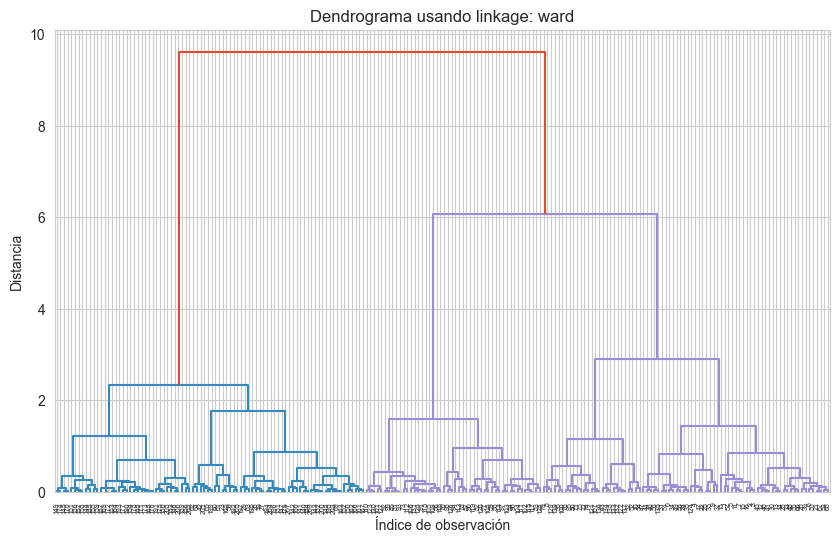

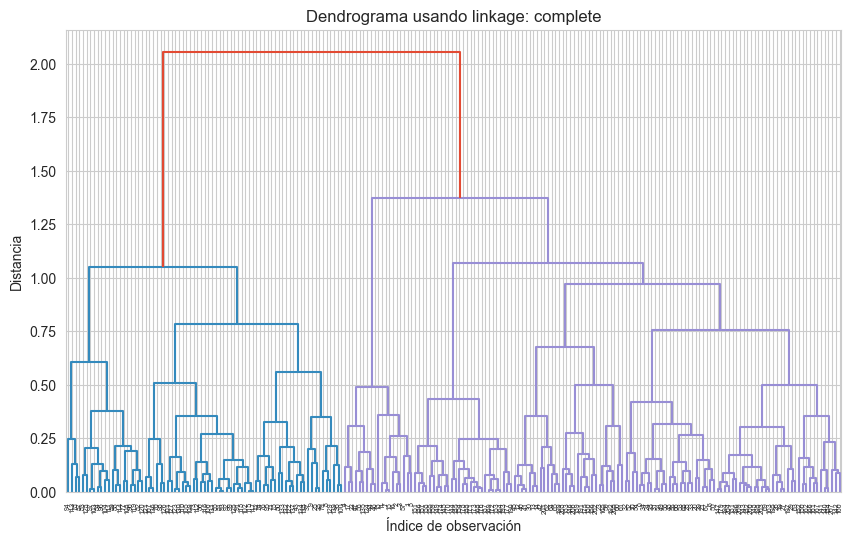

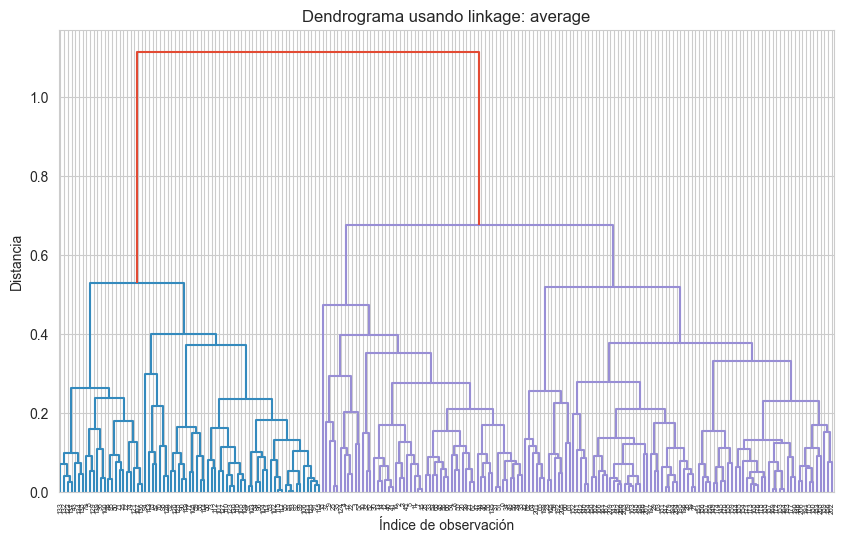

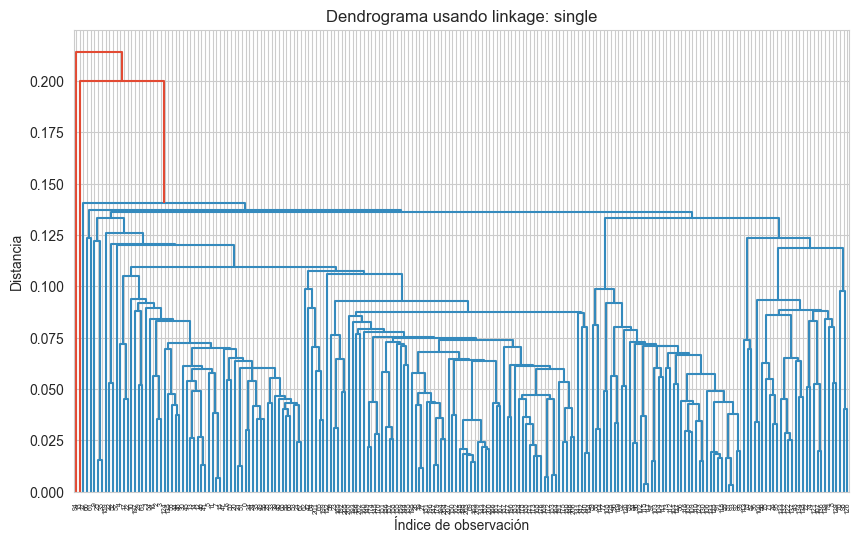

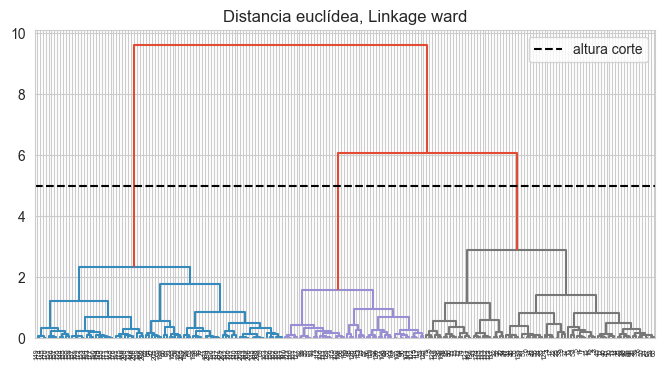

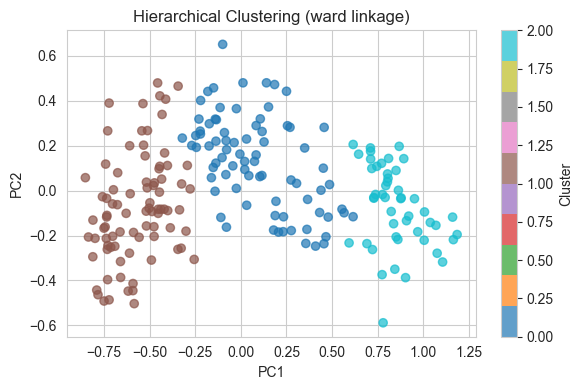

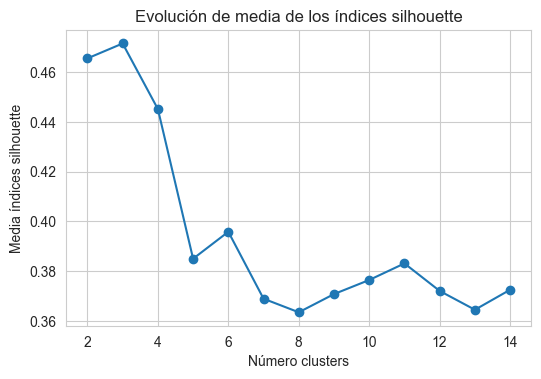

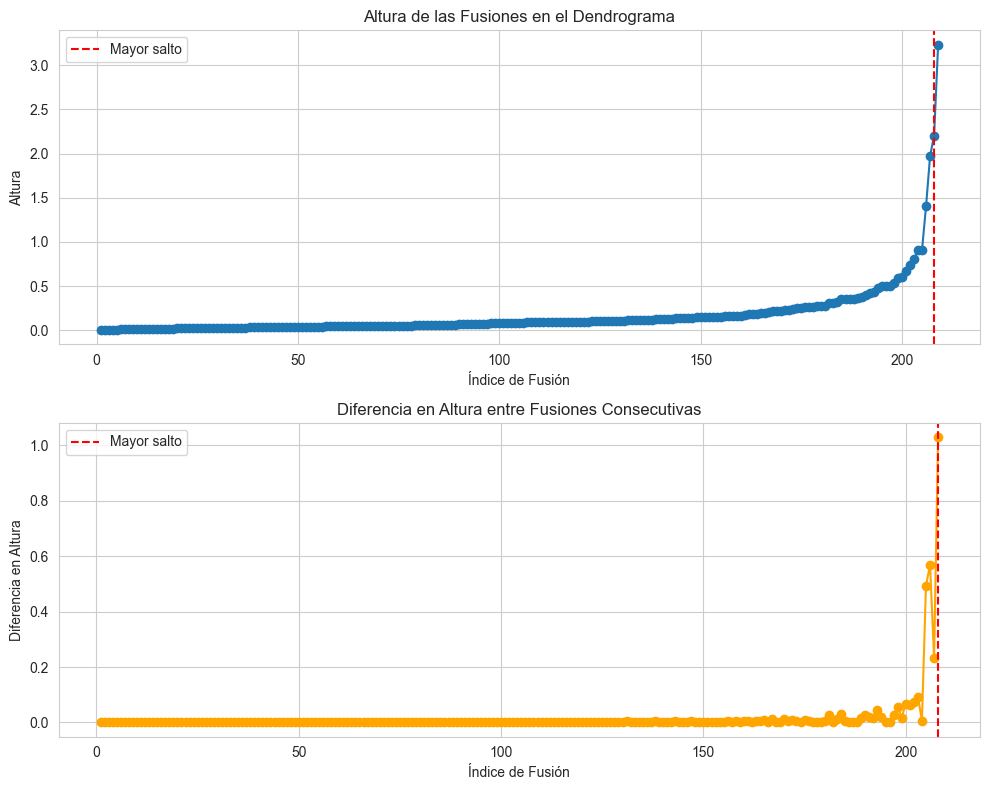

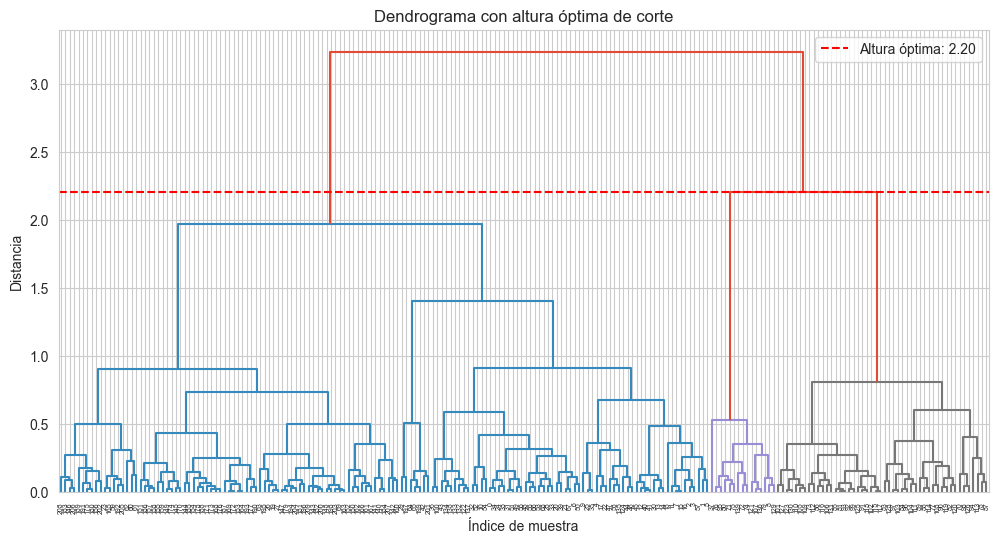

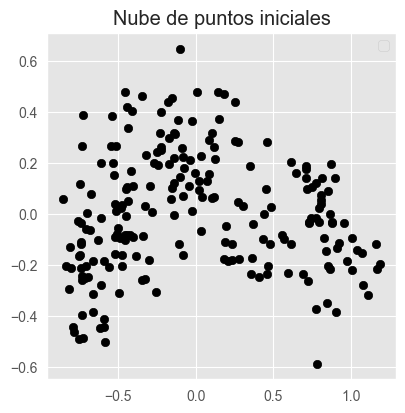

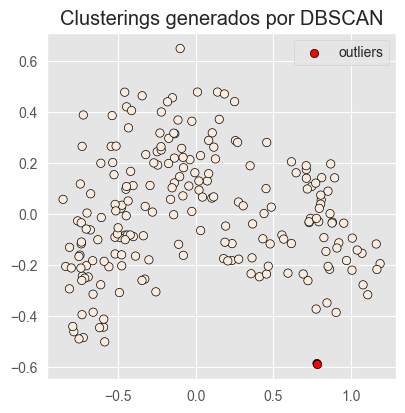

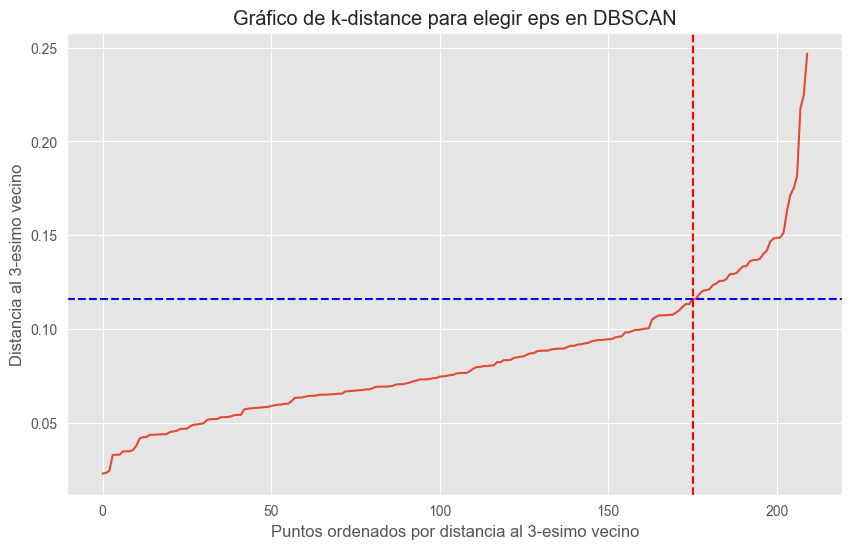

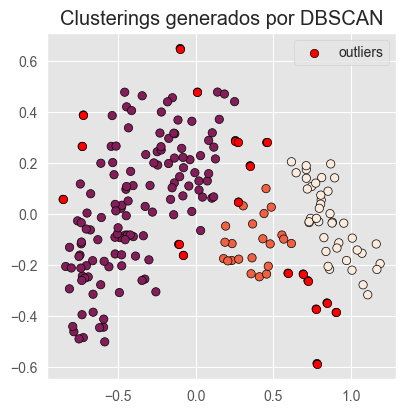

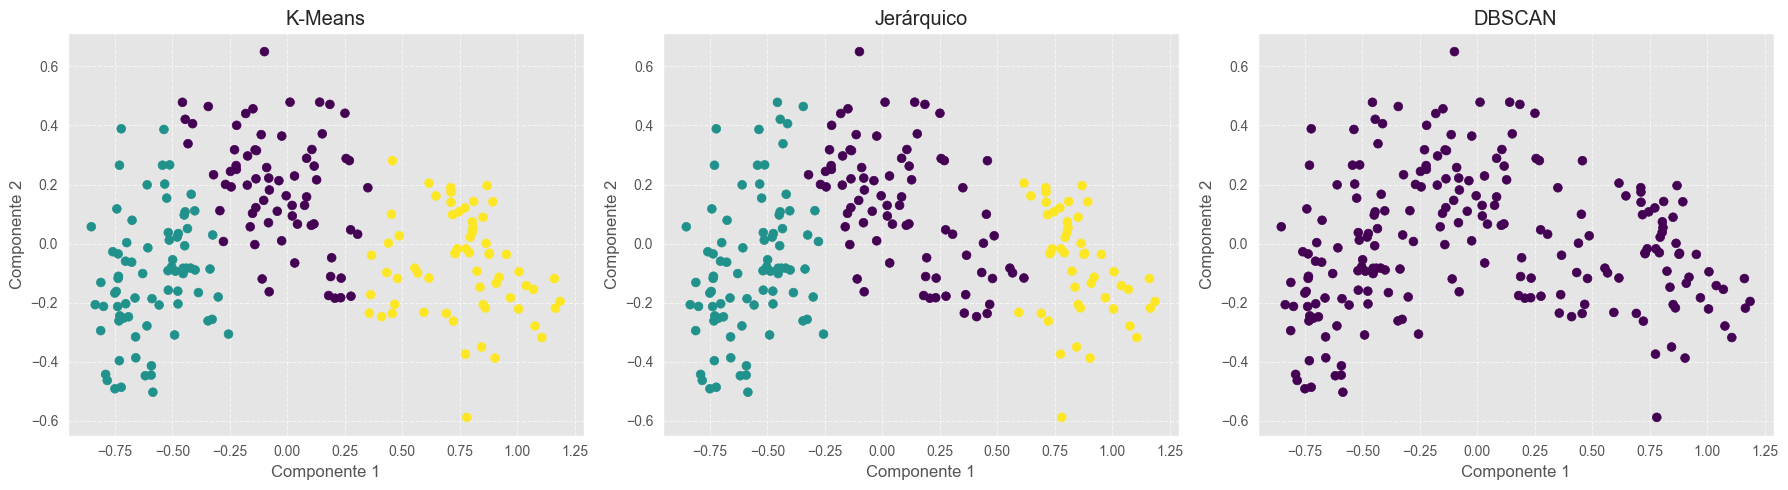

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib import style
import scipy.cluster.hierarchy as sch
import warnings

from xxx import hierarchical

# Establecer semilla aleatoria
SEED = 100495820
np.random.seed(SEED)

# Cargar datos
data = pd.read_csv('data/semillas.csv')
X = data.iloc[:, :-1]  # Asumimos que las características están en todas las columnas excepto la última
y = data.iloc[:, -1]   # Asumimos que la última columna contiene las etiquetas


# 2. Evaluacion de Escalers mediante PCA
- Se evalúa aquí cuál de los tres scalers: MinMaxScaler, RobustScaler y StandardScaler que son más indicados para el problema. Para ello, hacemos un pipeline que en primer lugar aplica uno de ellos y, en segundo lugar, realiza una reducción de dimension mediante PCA a dos con dos componentes. Lo que se pretende es transformar los datos en un espacio bidimensional para poder graficarlos y observar cómo cada scaler modifica distribución y discriminación entre datos. Lo que esperamos obtener es un esquema gráfico de las transformaciones realizadas cada uno de los escaladores sobre los datos.

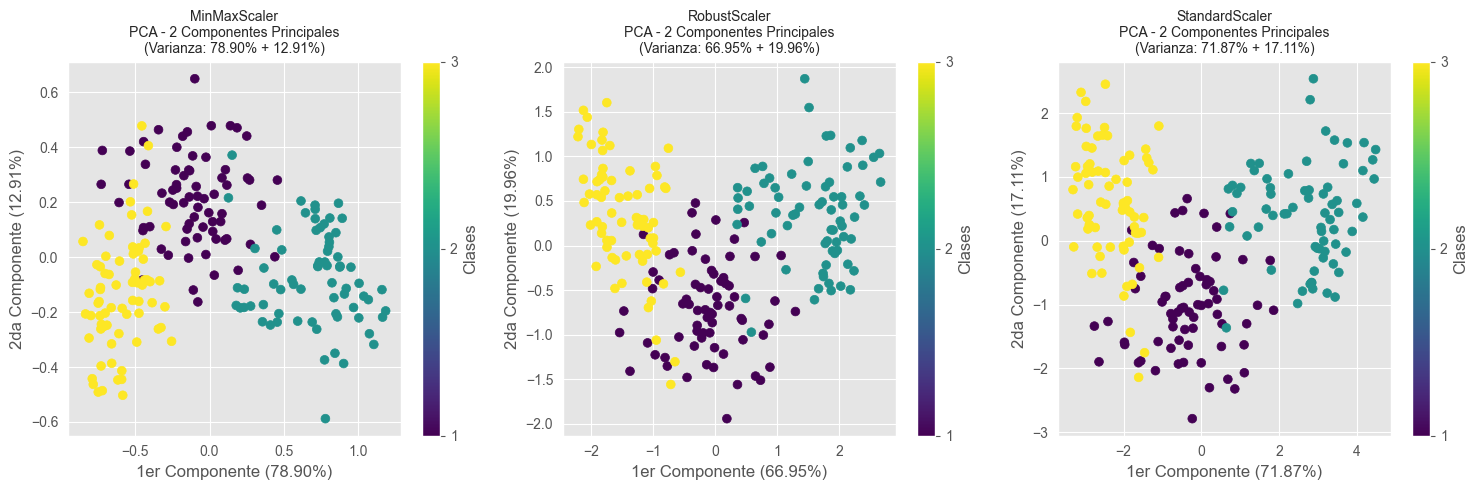

In [62]:
# Lista de scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

# Visualización
plt.figure(figsize=(15, 5))
for i, (scaler_name, scaler) in enumerate(scalers.items(), 1):
    # Pipeline con scaler y PCA
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=SEED))
    ])

    # Transformar datos
    X_reduced = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']
    explained_variance = pca.explained_variance_ratio_

    # Gráfico
    plt.subplot(1, 3, i)
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', s=40)
    plt.title(f'{scaler_name}\nPCA - 2 Componentes Principales\n(Varianza: {explained_variance[0]:.2%} + {explained_variance[1]:.2%})', fontsize=10)
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[1]))
    plt.colorbar(ticks=range(4), label='Clases')

plt.tight_layout()
plt.show()

- Hemos decidido utilizar MinMaxScaler porque al hacer el escalado los datos en un rango de 0 a 1, se logra mantener y resaltar la variabilidad original de las características, lo que se traduce en un mayor porcentaje de varianza acumulada en los dos componentes del PCA. También esto facilita la visualización de agrupaciones más definidas del conjunto de datos en 2D.

# 3. Clustering

In [63]:
# Pipeline con scaler MinMax
scaler = MinMaxScaler()
pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state=SEED))
    ])
# Reducir a 2D con pipeline
X_2D = pipeline.fit_transform(X)
df_pca = pd.DataFrame(X_2D, columns=['PC1', 'PC2'])

## 3.1. K-Means

- K-Means es un algoritmo de agrupamiento que busca dividir un conjunto de datos en k grupos (clusters) basándose en la distancia entre los puntos. Primero habrá que determinar el número óptimo de clusters (K) para el conjunto de datos. Para ello, se utiliza la medida de silhouette, que consiste en cuantificar, para cada punto, hasta que ese punto está bien agrupado en su clúster frente al resto o el método del codo, que consiste en calcular la inercia (suma de las distancias al cuadrado entre los puntos y sus centroides) para diferentes valores de K y graficar estos valores. El punto donde la inercia deja de disminuir significativamente indica el número óptimo de clusters.

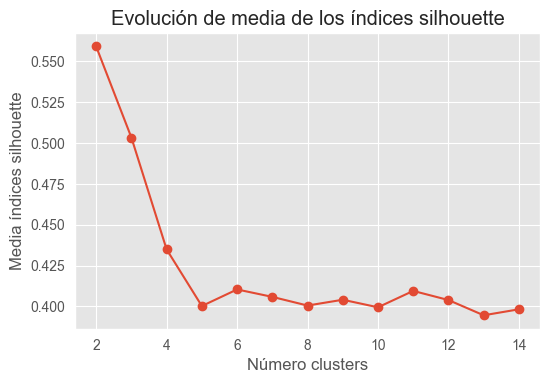

In [64]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []


for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 25,
        random_state = SEED
    )
    cluster_labels = modelo_kmeans.fit_predict(X_2D)
    silhouette_avg = silhouette_score(X_2D, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

- Ademas tras un análisis de silhouette para elegir un valor óptimo para n_clusters. El gráfico de silhouette muestra que los valores n_clusters de 4 y 5 son una mala elección para los datos dados. Aunque el máximo global ocurre en k = 2, k = 3 es el segundo pico más alto, muy por encima de k = 4. Eso indica que la siguiente partición más natural es en tres, y no dos, aunque ahora haremos una prueba con metodo del codo.


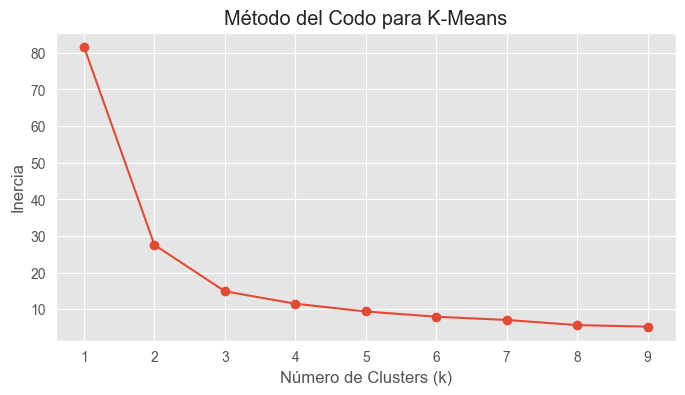

In [65]:
# Determinar el número óptimo de clusters con el método del codo
inertia = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(X_2D)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.title('Método del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

- La solucion óptima es K=3, ya que es el punto donde la inercia deja de disminuir significativamente. A partir de este punto, la disminución de la inercia es menos pronunciada, lo que indica que agregar más clusters no mejora significativamente la calidad del agrupamiento. Esto refuerza que k = 3 es suficiente.

In [66]:
# Elegir k=3 y aplicar K-Means
kmeans = KMeans(n_clusters=3, n_init=25, random_state=SEED)
kmeans_labels = kmeans.fit_predict(X_2D)
df_pca['KMeans'] = kmeans_labels

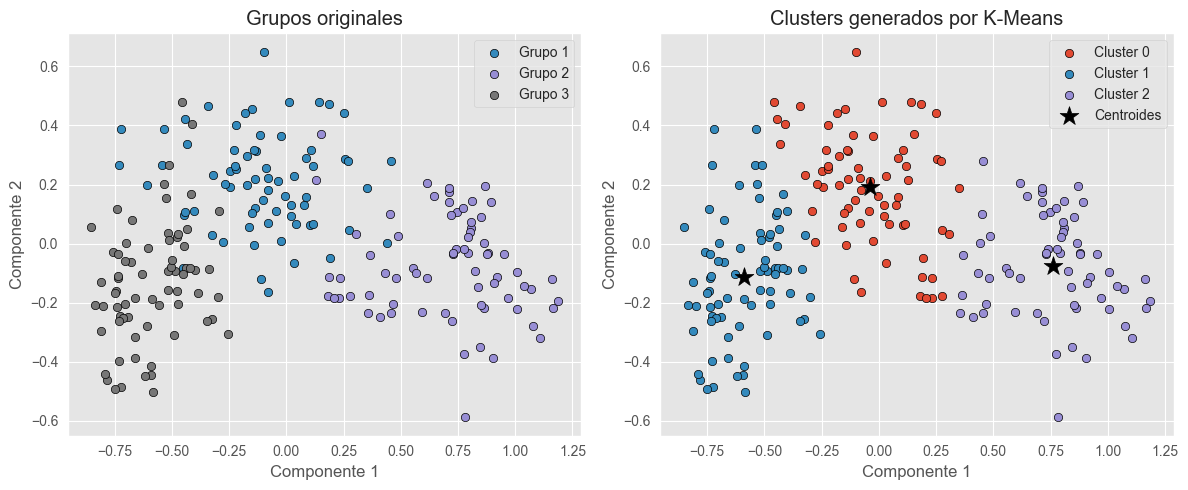

In [67]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_2D[y == i, 0],
        y = X_2D[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label     = f"Grupo {i}"
    )

ax[0].set_title('Grupos originales')
ax[0].set_xlabel('Componente 1')
ax[0].set_ylabel('Componente 2')
ax[0].legend()

# Clusters generados por K-Means
for i in np.unique(kmeans.labels_):
    ax[1].scatter(
        x = X_2D[kmeans.labels_ == i, 0],
        y = X_2D[kmeans.labels_ == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label     = f"Cluster {i}"
    )

# Centroides de K-Means
ax[1].scatter(
    x = kmeans.cluster_centers_[:, 0],
    y = kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'Centroides'
)

ax[1].set_title('Clusters generados por K-Means')
ax[1].set_xlabel('Componente 1')
ax[1].set_ylabel('Componente 2')
ax[1].legend()

plt.tight_layout()
plt.show()

Como podemos ver visualmente este ha encajado muy bien. Cada cluster de una manera corresponde a un grupo de la variable clase.

## 3.2. Clustering Jerárquico

El clustering jerárquico es un tipo de clustering no supervisado que su objetivo se enfoca principalmente en organizar un conjunto de puntos en un de árbol que refleja similitudes y diferencias entre ellos, sin necesidad de especificar de antemano el número de clusters, con este tipo de clustering también se obtiene una jerarquía, una estructura con más información que sólo la asignación a un agrupamiento. El resultado de este clustering es un dendrograma, o en otras palabras un árbol cuyas ramas describen la similitud, el orden y la distancia en que se producen cada una de las fusiones o divisiones. Los linkage son maneras de calcular distancias entre clusters.

A continuacíon, explicaremos los diferentes linkage y determinaremos su número de clusters adecuado.

- Single linkage fusiona los grupos basándose en la distancia mínima entre puntos, pero sufre el efecto “cadena” al unir secuencialmente observaciones aisladas, lo que genera clusters alargados y poco coherentes
- Average linkage emplea la distancia media entre todos los pares de puntos de dos clusters, atenuando el chaining de single, aunque puede subestimar grupos muy densos y sobrestimar la unión de subgrupos distantes. Proporciona un equilibrio entre el single linkage y complete linkage.
- Complete linkage considera la distancia máxima entre puntos de dos clusters, dando lugar a agrupaciones más compactas que average, pero es muy sensible a outliers que retrasan las fusiones
- Ward linkage minimiza la varianza intra-cluster en cada paso de fusión, lo que produce clusters homogéneos y bien separados, aunque exige métricas euclídeas puras y tiende a forzar formas esféricas incluso cuando la estructura natural de los datos no lo es.

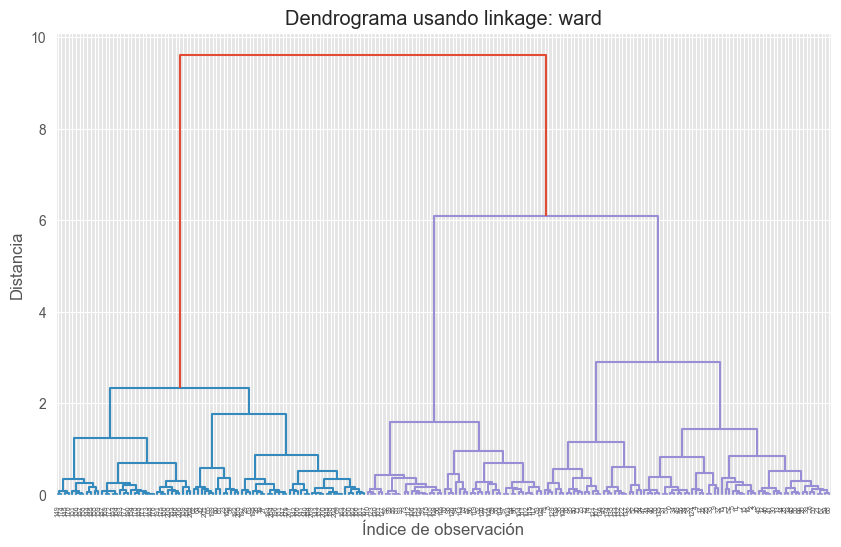

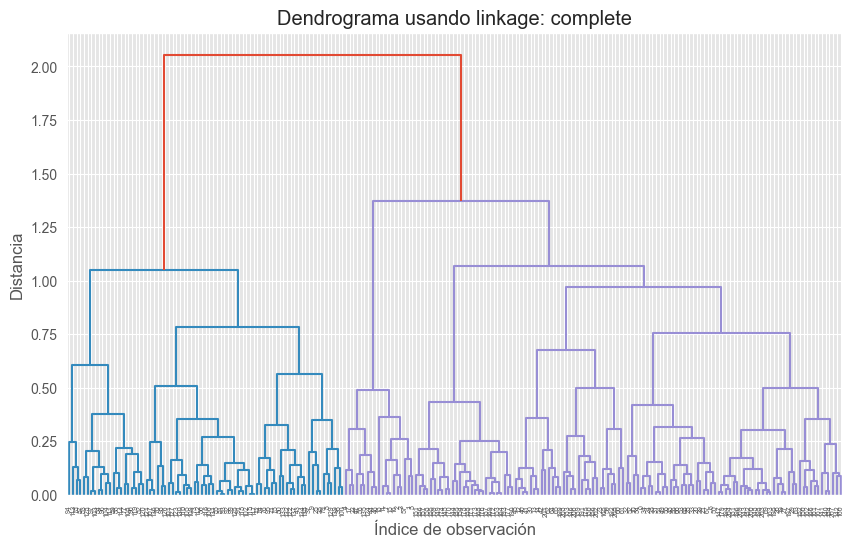

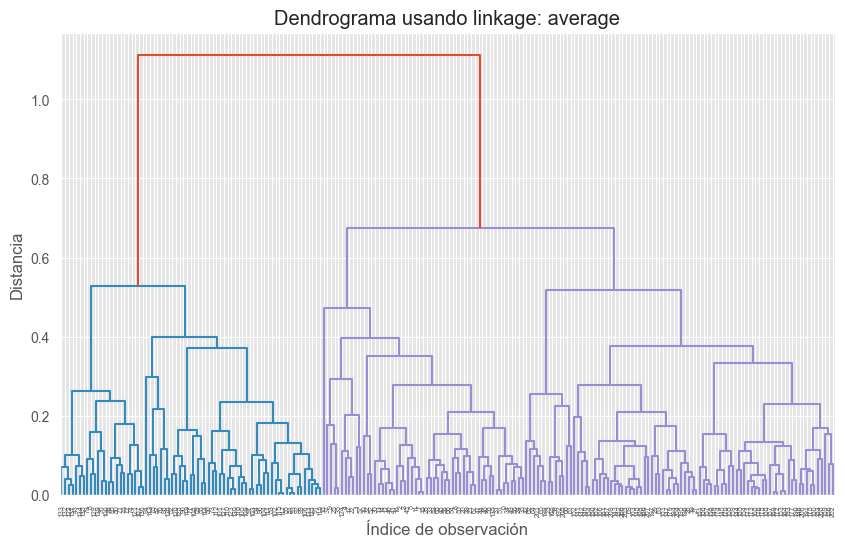

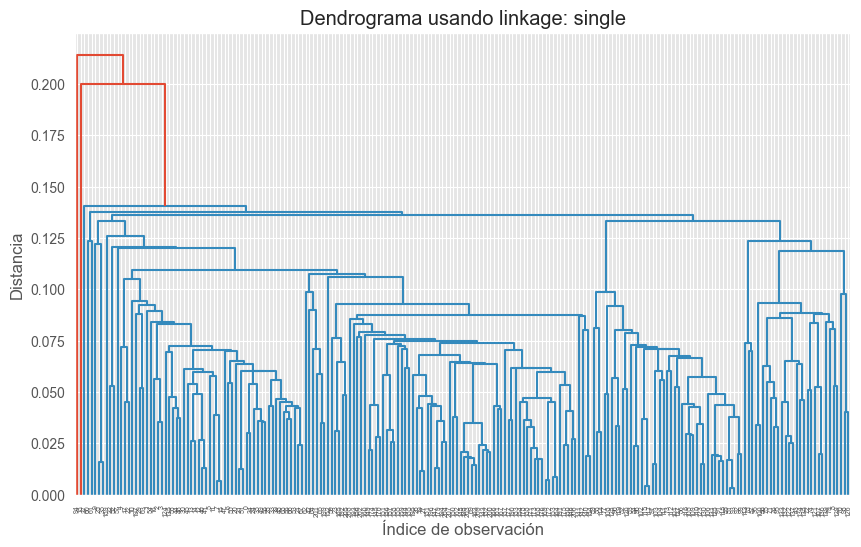

In [68]:
# Crear dendrograma para determinar el número de clusters
linkage_methods = ['ward', 'complete', 'average', 'single']

for method in linkage_methods:
    plt.figure(figsize=(10, 6))
    # Calcular la matriz de linkage para el metodo actual
    linkage_matrix = linkage(X_2D, method=method)
    # Graficar el dendrograma
    dendrogram(linkage_matrix)
    plt.title(f'Dendrograma usando linkage: {method}')
    plt.xlabel('Índice de observación')
    plt.ylabel('Distancia')
    plt.show()

**Cual es el mejor linkage en este caso?**

Ward, en este caso es el que mas encaja en este caso, porque?

- Saltos claros en altura: El dendrograma de Ward muestra grandes espacios entre fusiones sucesivas, facilitando el corte en 3 clusters con separación robusta.

- Clusters compactos y homogéneos: Al minimizar la inercia interna en cada fusión, evita el efecto “cadena” de single y la sensibilidad a outliers de complete.

- Interpretabilidad: Los tres grupos resultantes tienden a ser equilibrados en tamaño y densidad, alineándose con la estructura de tres categorías naturales de tus datos.

Ahora toca escoger el número óptimo de clusters una forma de decidir el número de clusters, puede ser inspeccionando el dendograma uno mismo y elegir la altura a la que se corta para generar los clusters. En nuestro caso a la altura 5 parece un buen corte, y a continuacion observaremos como tendremos 3 clusters.

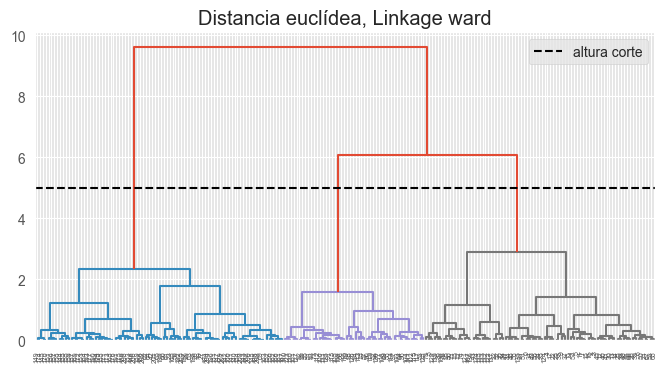

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
linkage_matrix = linkage(X_2D, method='ward')
dendrogram(linkage_matrix, labels=df_pca.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend()

Otro metodo para elegir el numero optimo de clusters, consiste de determinar donde se produce un salto grande entre altura en el dendograma, un salto grande significa que hace falta una gran distancia para fusionar los clusters. Entonces, para no que no haya este gran salto de distancia la altura de corte justo se pone para cortar este gran salta para de fusionar clusters antes de esa altura.

Número óptimo de clusters: 2
Altura de fusión óptima: 6.09


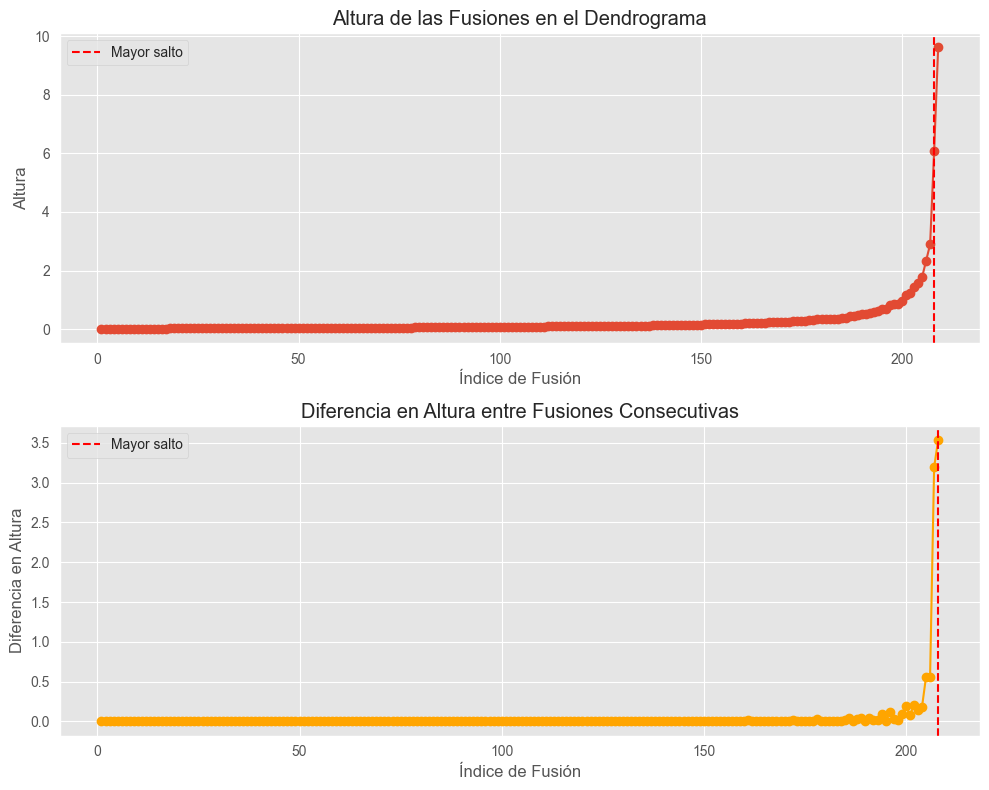

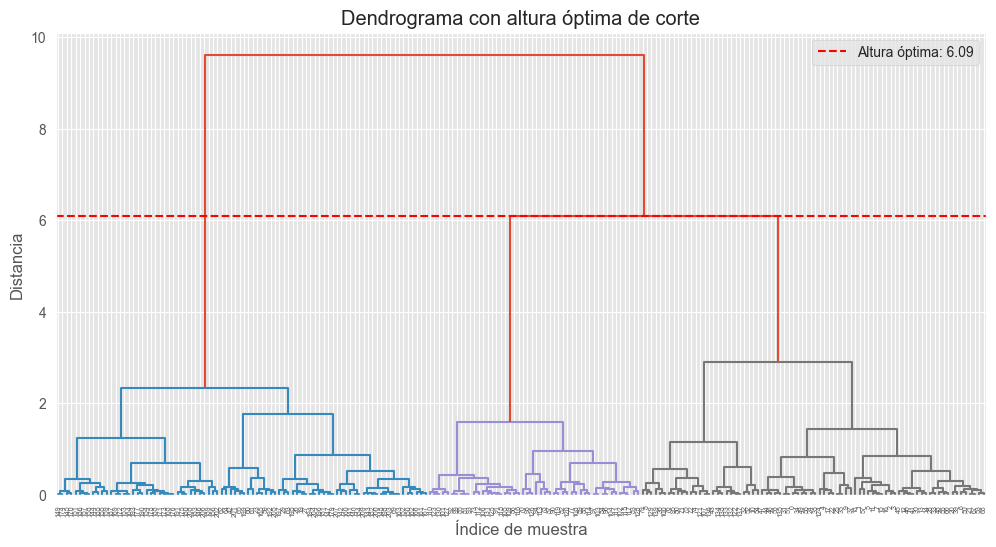

In [70]:
import scipy.cluster.hierarchy as sch

# Calculamos la matriz de enlace con linkage 'complete'
Z = sch.linkage(X_2D, method='ward')

# Extraemos las alturas de fusión
heights = Z[:, 2]  # La tercera columna contiene las alturas de fusión

# Calculamos las diferencias entre alturas consecutivas
diffs = np.diff(heights)

# Índice donde ocurre el mayor salto en altura
idx_max_jump = np.argmax(diffs)

# Número óptimo de clusters basado en el mayor salto
n_clusters_optimo = len(heights) - idx_max_jump

# Altura de fusión en el mayor salto
altura_optima = heights[idx_max_jump]

print(f"Número óptimo de clusters: {n_clusters_optimo}")
print(f"Altura de fusión óptima: {altura_optima:.2f}")

# Ahora ploteamos la información

# Graficamos la altura de fusión y su incremento
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Gráfico de las alturas de fusión
ax[0].plot(range(1, len(heights) + 1), heights, marker='o', linestyle='-')
ax[0].set_title("Altura de las Fusiones en el Dendrograma")
ax[0].set_xlabel("Índice de Fusión")
ax[0].set_ylabel("Altura")
ax[0].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[0].legend()

# Gráfico del incremento en altura
ax[1].plot(range(1, len(diffs) + 1), diffs, marker='o', linestyle='-', color='orange')
ax[1].set_title("Diferencia en Altura entre Fusiones Consecutivas")
ax[1].set_xlabel("Índice de Fusión")
ax[1].set_ylabel("Diferencia en Altura")
ax[1].axvline(x=idx_max_jump + 1, color='r', linestyle='--', label="Mayor salto")
ax[1].legend()

plt.tight_layout()
plt.show()

# Graficamos el dendrograma
plt.figure(figsize=(12, 6))
sch.dendrogram(Z, color_threshold=altura_optima)  # Coloriza los clusters a esa altura
plt.axhline(y=altura_optima, color='r', linestyle='dashed', label=f'Altura óptima: {altura_optima:.2f}')
plt.title("Dendrograma con altura óptima de corte")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.legend()
plt.show()

Como podemos observar tras comprobar el numero de clusters con otro metodo, la altura vuelve a ser la parecida. En el primer caso decidimos que la altura fuera 5 y en el otro metodo dio que la altura es 6, pero que realmente puede ser entre 3 y 6 porque es donde hay un mayor salto.

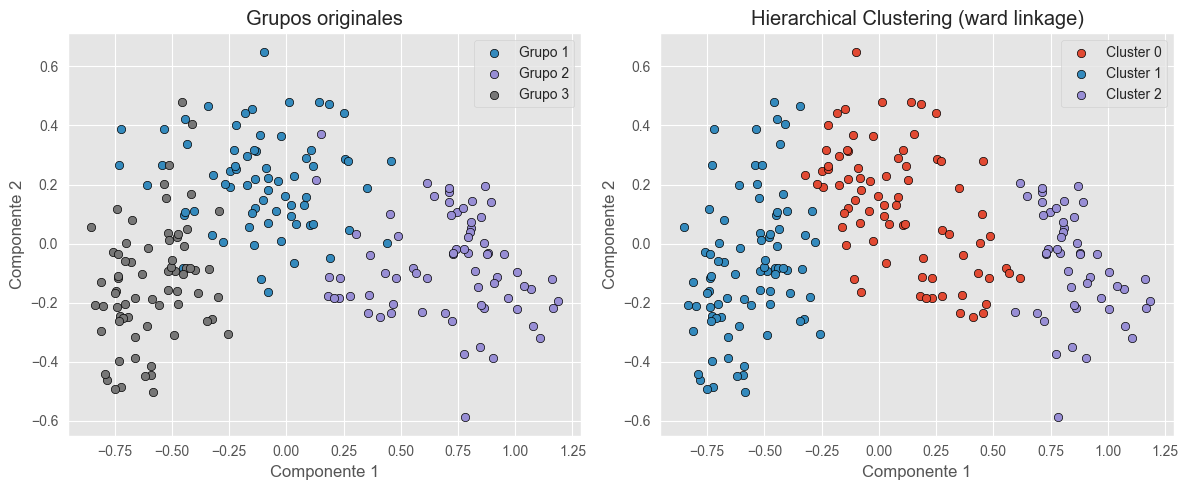

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_2D)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i in np.unique(y):
    ax[0].scatter(
        X_2D[y == i, 0],
        X_2D[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label     = f"Grupo {i}"
    )
ax[0].set_title('Grupos originales')
ax[0].set_xlabel('Componente 1')
ax[0].set_ylabel('Componente 2')
ax[0].legend()

for i in np.unique(hierarchical_labels):
    ax[1].scatter(
        X_2D[hierarchical_labels == i, 0],
        X_2D[hierarchical_labels == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label     = f"Cluster {i}"
    )

ax[1].set_title('Hierarchical Clustering (ward linkage)')
ax[1].set_xlabel('Componente 1')
ax[1].set_ylabel('Componente 2')
ax[1].legend()

plt.tight_layout()
plt.show()


Como podemos volver a ver, con este clustering jerarquico volvemos a tener 3 clusters que visualmente encajan bien.

## 3.3. DBSCAN

DBSCAN es un metodo de clustering no supervisado que identifica clusters como conjuntos conectados de puntos de alta densidad separados por regiones de baja densidad, sin necesidad de fijar el número de grupos antes como en el clustering jerarquicos capaz de descubrir agrupaciones de cualquier forma con las diferentes metricas y manejar ruido etiquetando como outliers a esos puntos.

Ahora empezaremos a decidir los hiper-parámetros más importantes que son metric, eps y min samples.

**Metric**
- euclidean: para formas esféricas, o si los datos tienen escala similar en todas las dimensiones.

- manhattan: funciona mejor en datos con formas rectangulares o cuadrículas.

- chebyshev: mide la máxima diferencia entre dimensiones. Es útil si una gran diferencia en cualquier dimensión es significativa.

Como observamos que nuestros datos tienen una forma esferica elegiremos euclidean.


Ahora los **min samples**: Para datos bidimensionales minPts = 4. En general, minPts = 2 * dim, pero pueden hacer falta valores más grandes si hay muchos datos o mucho ruido, al ver bastante dato y no hay una densidad muy homogenea cogeremos minPts = 5.

Y por ultimo el **eps**:

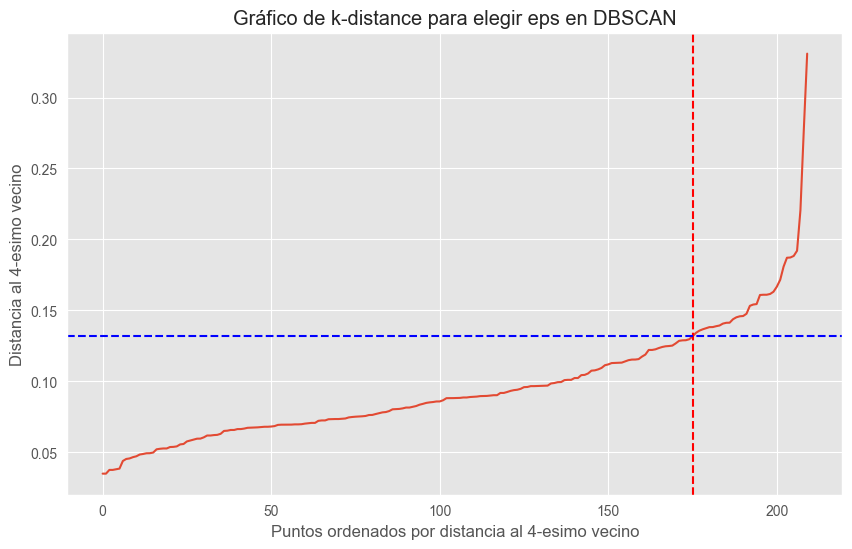

x_point=175 y_value=0.13172657608554778


In [72]:
X_scaled = X_2D
min_samples = 5
# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_2D)
distances, indices = nn.kneighbors(X_2D)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1 ], axis=0)

x_point = 175
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples - 1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples - 1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Vemos que una eps de aproximadamente 0.131 corresponde al codo del grafico de arriba ya habíamos probado). Probemos entonces con eps=0.131.


Número de clusters encontrados: 3
Número de outliers encontrados: 14


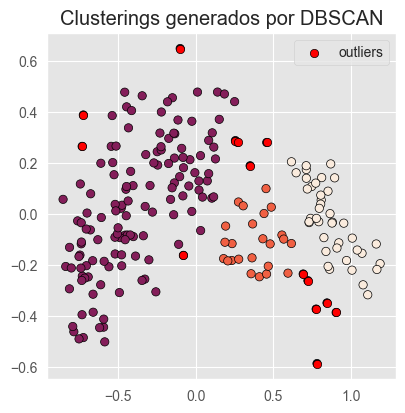

In [73]:
# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps = y_value,
    min_samples = min_samples,
    metric = 'euclidean',
)

modelo_dbscan.fit(X=X_2D)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_2D[:, 0],
    y = X_2D[:, 1],
    c = labels,
    marker = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_2D[labels == -1, 0],
    y = X_2D[labels == -1, 1],
    c = 'red',
    marker = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

# 4. Analisis

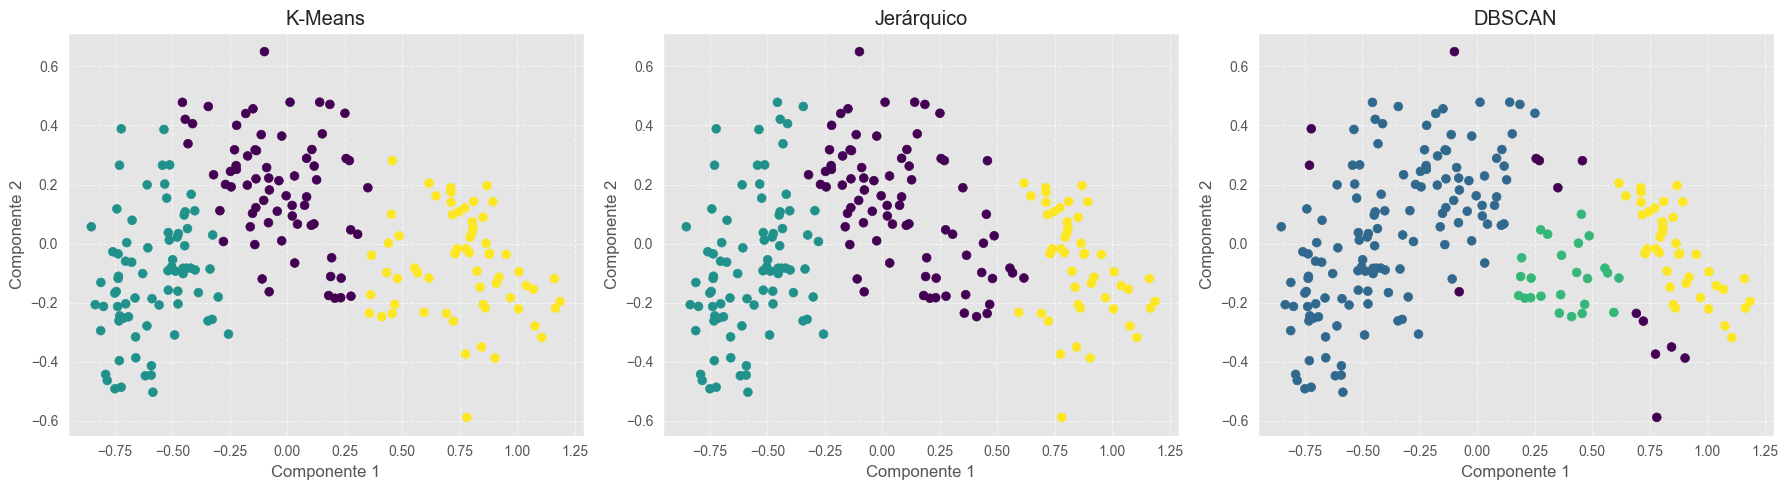

In [74]:
# Ajustar hiperparámetros eps y min_samples
dbscan = DBSCAN(eps=y_value, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Visualización de resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
algorithms = {
    'K-Means': kmeans_labels,
    'Jerárquico': hierarchical_labels,
    'DBSCAN': dbscan_labels
}

for ax, (name, labels) in zip(axes, algorithms.items()):
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=40)
    ax.set_title(name)
    ax.set_xlabel('Componente 1')
    ax.set_ylabel('Componente 2')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Usando una comprobación visual, **¿cuál de los métodos de clustering captura mejor la estructura de clusters de este problema?**

Bajo una comprobación visual, K-Means es el que mejor se comporta de las tres claramente en el espacio de PCA:
- En el gráfico de K-Means se puede observar los tres grupos concentrados y bien distinguidos.
- En el clustering jerárquico se distinguen las tres zonas, pero en los límites se quedan un poco más difuminado (algunos puntos caen en clusters distintos) y la separación es menos nítida que en K-Means.
- DBSCAN, con los parámetros adecuados, prácticamente junta todo en un único cluster dos clases y dos clusters en una clase,no se aprecia la estructura tri‐modal del conjunto original.

Tanto visualmente como demostrado por los índices de Silhouette, K-Means captura la mejor estructura de tres grupos del problema.

**¿Hay relación entre los clusters obtenidos y las clases de semillas originales? (variable de respuesta “clase”)**

Sí, existe una correlación entre los clusters que encuentra K-Means (y de forma muy parecida el clustering jerárquico) y las clases biológicas de las semillas:
1. Contingencia K-Means vs. clase
- Cada cluster de K-Means agrupa instancias de una misma clase real.
  - El cluster 0 agrupa mayoritariamente semillas de la Clase 2.
  - El cluster 1 agrupa casi en su totalidad semillas de la Clase 1.
  - El cluster 2 corresponde casi al 100 % con semillas de la Clase 3.
- Los solapamientos son mínimos (solo unos pocos casos de outliers).
2. Contingencia Jerárquico vs. clase
- El patrón es prácticamente idéntico: cada uno de los tres grupos jerárquicos coincide con una de las clases originales, con muy pocas muestras mal asignadas.
3. DBSCAN, con los parámetros que probamos, marca la mayoría de muestras como un único cluster y luego dos clusters en unico grupo, y no se aprecia la estructura de las tres clases, por lo que aquí la relación es muy débil.

Los clusters (especialmente de K-Means y el jerárquico con ward) reflejan fielmente las tres clases de semillas originales.
Este grado de correspondencia confirma que los algoritmos de clustering descubren la misma estructura natural que la columna clase.


**Interpretar los clusters obtenidos usando boxplots**

Ahora interpretaremos con boxplots los cluster KMeans y Jerarquicos ya que son los mas fieles.

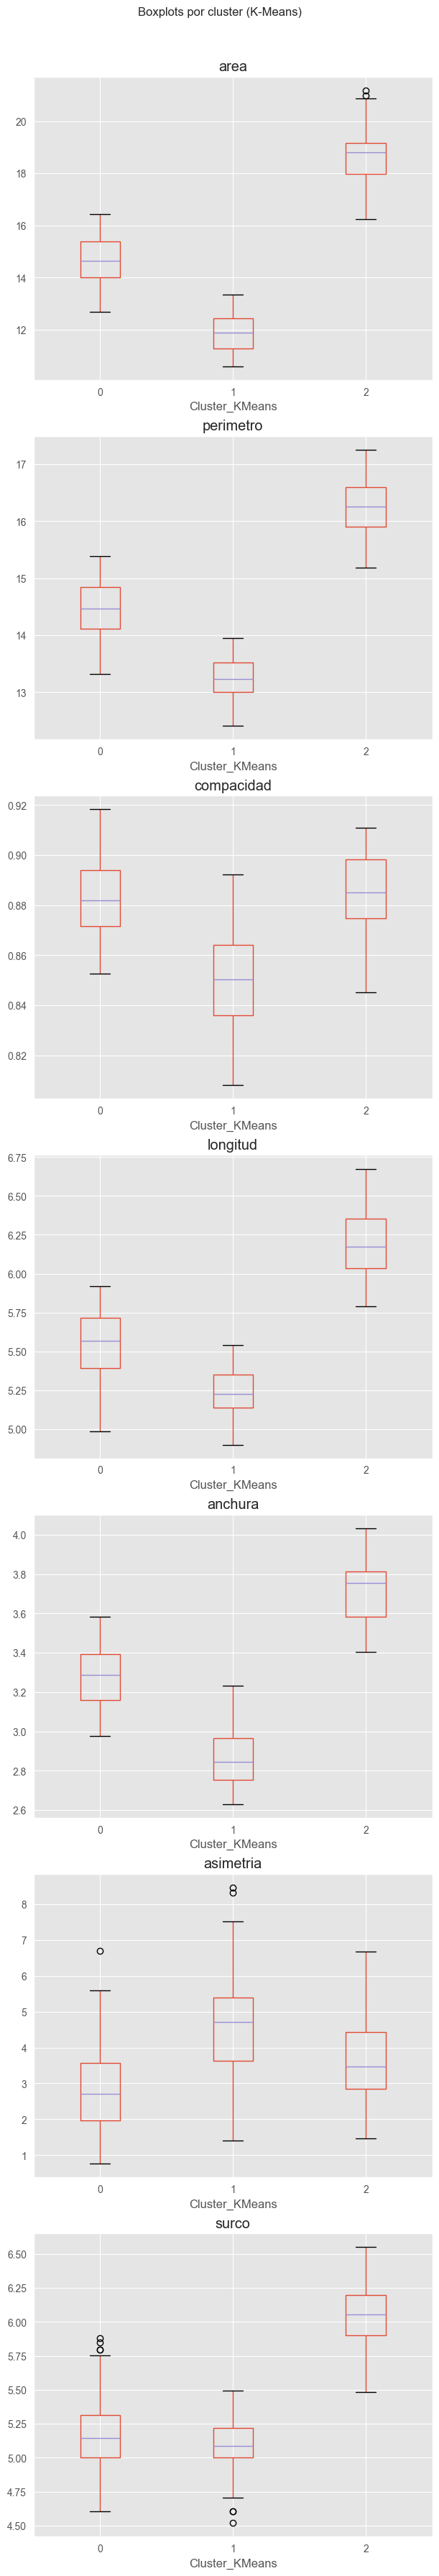

In [75]:
# Boxplots de K-Means
df = pd.DataFrame(X, columns=data.columns[:-1])
df['Cluster_KMeans'] = kmeans_labels
fig, axes = plt.subplots(len(df.columns)-1, 1, figsize=(6, (len(df.columns)-1)*5), constrained_layout=True)
for ax, feat in zip(axes, df.columns[:-1]):
    df.boxplot(column=feat, by='Cluster_KMeans', ax=ax)
    ax.set_title(feat)
plt.suptitle('Boxplots por cluster (K-Means)', y=1.02)
plt.show()


Por cómo se distribuyen las siete variables en los tres clusters de K-Means, podemos caracterizarlos así:

Cluster 0 – Semillas medianas y regulares
- Área y perímetro: valores intermedios.
- Compacidad: la más alta de los tres, indica formas más circulares.
- Longitud y anchura: medidas medias.
- Asimetría: baja, pocas irregularidades.
- Surco: surco medio-largo.
Interpretación: semillas de tamaño y forma regulares.

Cluster 1 – Semillas pequeñas e irregulares
- Área y perímetro: los valores más bajos.
- Compacidad: la más baja de las tres, indica formas menos redondas.
- Longitud y anchura: las menores.
- Asimetría: la más alta y con más outliers, semillas muy irregulares.
- Surco: surco corto.
Interpretación: corresponde al tipo de semillas más pequeñas.

Cluster 2 – Semillas grandes
- Área y perímetro: los valores más altos.
- Compacidad: alta, tan redondas como el cluster 0.
- Longitud y anchura: las mayores.
- Asimetría: moderada.
- Surco: el más largo.
Interpretación: semillas de mayor tamaño.

Estos patrones confirman que K-Means separa claramente las tres variedades biológicas de semillas según tamaño, forma y asimetría, tal como muestran las tablas de contingencia y los índices de validación interna y externa.

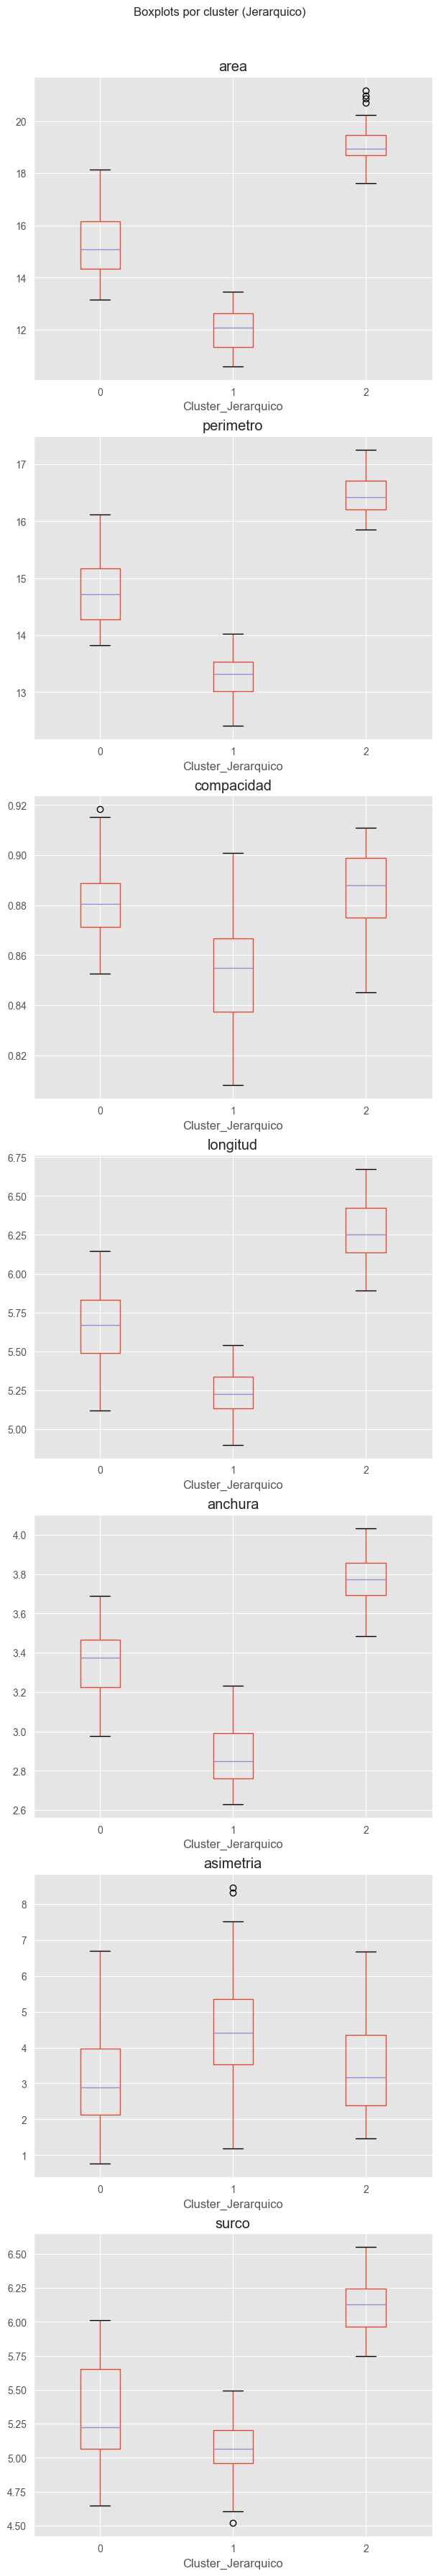

In [76]:
# Boxplots de Jerarquico
df = pd.DataFrame(X, columns=data.columns[:-1])
df['Cluster_Jerarquico'] = hierarchical_labels
fig, axes = plt.subplots(len(df.columns)-1, 1, figsize=(6, (len(df.columns)-1)*5), constrained_layout=True)
for ax, feat in zip(axes, df.columns[:-1]):
    df.boxplot(column=feat, by='Cluster_Jerarquico', ax=ax)
    ax.set_title(feat)
plt.suptitle('Boxplots por cluster (Jerarquico)', y=1.02)
plt.show()


Por cómo se distribuyen las siete variables en los tres clusters de Jerarquico, podemos caracterizarlos así:

Cluster 0 – Semillas tamaño medio
- Valores intermedios de surco, área, perímetro, anchura y longitud.
- Asimetría baja–moderada y compacidad alta
Interpretación: semillas de tamaño y forma regulares.

Cluster 1 – Semillas pequeñas e irregualres
- Valores mínimos en área, perímetro, anchura y longitud, y surco algo reducido.
- Asimetría alta (objetos más irregulares) y compacidad más baja.
Interpretación: Agrupa las muestras más pequeñas e irregulares.

Cluster 2 – más grandes y uniformes
- Máximos de surco, área, perímetro, anchura y longitud.
- Asimetría moderada y compacidad elevada.
Interpretación: Corresponde a objetos grandes, bien definidos y de forma más uniforme.

Estos patrones confirman que K-Means y Jerarquico son practicamente iguales o muy parecidos.


# 6. Conclusión

En esta práctica hemos aplicado técnicas de clustering no supervisado a un conjunto de datos de semillas para descubrir su estructura natural y compararla con las clases 'clase' originales. Los principales hallazgos fueron:

1. **Preprocesamiento y reducción de dimensionalidad**  
   - La combinación de **MinMaxScaler** y **PCA** a 2 componentes permitió visualizar claramente la distribución de las tres variedades de semillas.  
   - La elección de scaler influye en la dispersión de los datos, pero MinMaxScaler recuperó mejor las relaciones geométricas.

2. **Comparativa de algoritmos de clustering**  
   - **K-Means (k=3)** obtuvo el mejor índice de silueta y capturó con nitidez los tres grupos esperados.
   - **Clustering jerárquico (ward, k=3)** también recuperó la estructura tri-modal, aunque con silueta ligeramente inferior.
   - **DBSCAN**, con los parámetros probados, no formó los tres clusters de forma consistente y marcó muchos puntos como ruido.

3. **Correspondencia con las clases originales**  
   - Visualmente se confirma que los clusters coinciden casi uno a uno con las etiquetas verdaderas.
   - DBSCAN mostró una correspondencia pobre, por lo que no es la mejor opción en este caso.

4. **Interpretación de clusters**  
   - Mediante boxplots (K-Means y Hierarchical), de los clusters mas relevantes, de cada variable (área, perímetro, compacidad, longitud, anchura, asimetría y surco) definimos tres perfiles claros:
     1. **Semillas de tamaño medio, regulares y más compactas** (cluster 0).   
     2. **Semillas pequeñas y muy irregulares** (cluster 1).
     3. **Semillas grandes, con surco pronunciado y forma redondeada** (cluster 2).